# Regression using a single neuron

Dataset:
https://www.kaggle.com/srolka/ecommerce-customers?select=Ecommerce+Customers.csv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import grad, jit

from jax.tree_util import tree_map
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

Mounting drive into Colab to load the dataset

In [2]:
from google.colab import drive 

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
ecom_data = pd.read_csv('/content/drive/MyDrive/jax_datasets/ecommerce_data.csv')

ecom_data.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


In [7]:
ecom_data = ecom_data.drop(['Email', 'Address', 'Avatar'], axis = 1)

ecom_data.shape

(500, 5)

Separate predictor and target dataframes are created

In [8]:
X = ecom_data.drop('Yearly Amount Spent', axis = 1)

y = ecom_data['Yearly Amount Spent']

Data is split into Train(0.8) and Test set(0.2)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 4), (100, 4), (400,), (100,))

Training and testing predictor dataframes are scaled

In [18]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                              columns = X_train.columns)

X_test_scaled = pd.DataFrame(scaler.transform(X_test),
                             columns = X_test.columns)

In [19]:
X_train_scaled.describe()

,Avg. Session Length,Time on App,Time on Website,Length of Membership
count,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02
mean,2.682299e-15,-4.085621e-16,-3.159695e-15,-2.842171e-16
std,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00
min,-3.601062e+00,-3.436612e+00,-2.588089e+00,-3.320615e+00
25%,-6.884145e-01,-6.921006e-01,-7.045711e-01,-5.909415e-01
50%,2.091691e-02,-6.965488e-02,2.510030e-02,-3.903883e-03
75%,6.332249e-01,7.261131e-01,6.603220e-01,5.854794e-01
max,3.101492e+00,3.123495e+00,2.611492e+00,2.909588e+00


In [20]:
X_test_scaled.head()

,Avg. Session Length,Time on App,Time on Website,Length of Membership
0,-0.979813,0.334053,0.169088,-0.455518
1,-0.348086,0.304865,0.310549,0.910913
2,-1.225150,-1.789130,-0.133379,-0.047477
3,0.855180,-0.470429,-1.812147,-0.148117
4,0.548108,-0.898346,-1.437523,1.955721


Numpy arrays are converted into JAX arrays(Device arrays)

In [21]:
X_train, X_test, y_train, y_test = jnp.array(X_train_scaled.to_numpy(), dtype = jnp.float32),\
                                   jnp.array(X_test_scaled.to_numpy(), dtype = jnp.float32),\
                                   jnp.array(y_train.to_numpy(), dtype = jnp.float32),\
                                   jnp.array(y_test.to_numpy(), dtype = jnp.float32)

X_train.shape, X_test.shape, y_train.shape, y_test.shape                              

((400, 4), (100, 4), (400,), (100,))

In [29]:
W = jnp.zeros(X_train.shape[1:])

b = 0.

lr = 0.01    

n_iterations = 500  

Prediction and loss functions are defined. Loss function is Mean squared error.

In [30]:
def predict_y(W, b, X):
    return jnp.dot(X, W) + b

In [31]:
def loss_fn(W, b, X, y):
    error = predict_y(W, b, X) - y
    return jnp.mean(jnp.square(error))

Parameters update functions are defined using tree_map functions

In [32]:
def update_W(W, b, X, y, lr):
    grad_W = grad(loss_fn, argnums = 0)(W, b, X, y)

    return tree_map(lambda W, grad_W, lr : W - lr * grad_W, 
                    W, grad_W, lr)

def update_b(W, b, X, y, lr):
    grad_b = grad(loss_fn, argnums = 1)(W, b, X, y)

    return tree_map(lambda b, grad_b, lr:  b - lr * grad_b,
                    b, grad_b, lr )

The training loop is started.Note that we are jitting the update parameters function for faster execution

In [33]:
loss_history = []

for i in range(n_iterations):
    loss = loss_fn(W, b, X_train, y_train)

    if (i + 1) % 100 == 0:
      print('Iteration', i+1, 'Loss:', loss)  

    loss_history.append(loss)

    #W = update_W(W, b, X_train, y_train, lr)
    #b = update_b(W, b, X_train, y_train, lr)

    W = jit(update_W)(W, b, X_train, y_train, lr)
    b = jit(update_b)(W, b, X_train, y_train, lr)

Iteration 100 Loss: 4785.8525
Iteration 200 Loss: 179.00359
Iteration 300 Loss: 98.14725
Iteration 400 Loss: 96.72752
Iteration 500 Loss: 96.702576


Iterations Vs Training Loss plot is obtained

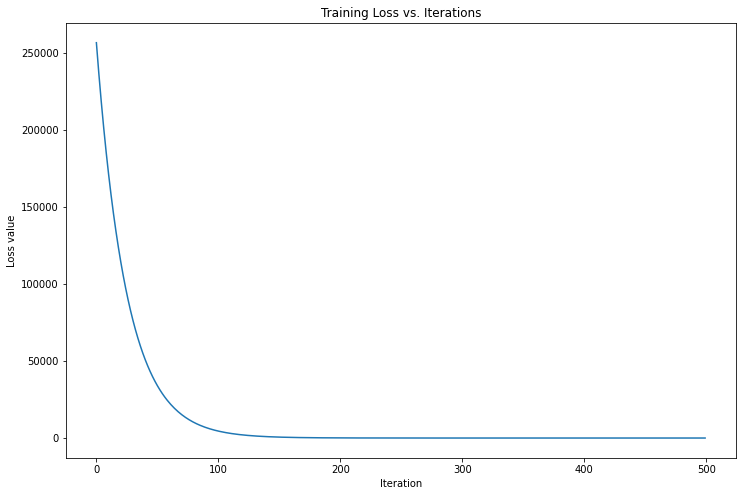

In [34]:
_, ax = plt.subplots(figsize = (12, 8))

ax.set(xlabel = 'Iteration', ylabel = 'Loss value', title = 'Training Loss vs. Iterations')
plt.plot(loss_history)

The parameter i.e coefficients and bias are obtained

In [35]:
W, b

(DeviceArray([25.171598  , 38.69262   ,  0.14170422, 60.81936   ], dtype=float32),
 DeviceArray(500.67734, dtype=float32, weak_type=True))

In [36]:
y_pred = predict_y(W, b, X_test)

y_pred

DeviceArray([461.25888, 559.1566 , 397.7058 , 494.73627, 598.4568 ,
             379.75964, 520.76587, 621.43536, 620.56934, 374.73096,
             554.3387 , 473.50464, 506.3338 , 462.7075 , 553.2627 ,
             643.75244, 553.3014 , 430.15402, 349.7583 , 535.68646,
             409.30115, 401.5279 , 448.5638 , 288.1085 , 599.9244 ,
             514.3324 , 508.47632, 443.35883, 282.19254, 447.85687,
             414.04968, 549.4665 , 555.11926, 571.45056, 422.47424,
             543.1544 , 562.09937, 541.60565, 559.9704 , 494.18713,
             567.09344, 353.23505, 332.26962, 546.91956, 325.0351 ,
             754.36633, 554.27295, 498.4975 , 485.67645, 395.20007,
             538.3428 , 611.79706, 548.2168 , 530.43134, 629.2355 ,
             602.54333, 571.464  , 565.4763 , 515.9484 , 602.14746,
             533.096  , 550.18286, 556.8523 , 370.55365, 449.61865,
             521.1915 , 592.44727, 336.84424, 457.77173, 495.04846,
             513.2444 , 553.6077 , 479.99335, 50

R square and RMSE values for test set are obtained

In [37]:
print('Testing Score:', r2_score(y_test, y_pred))

Testing Score: 0.9844158008339569


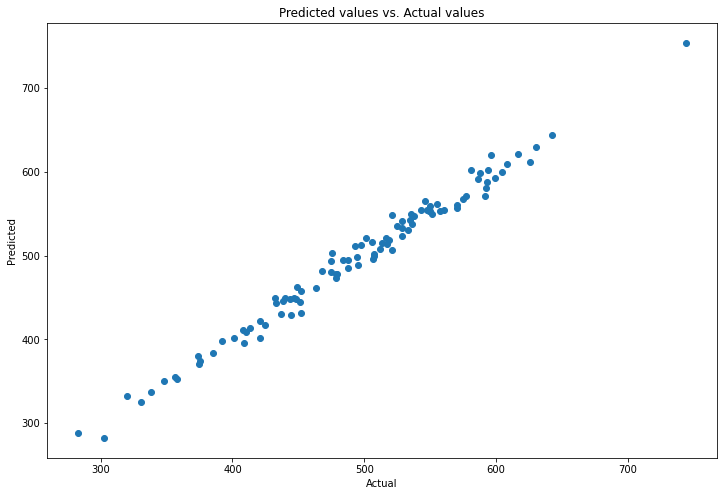

In [38]:
_, ax = plt.subplots(figsize = (12, 8))

ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Predicted values vs. Actual values')

plt.scatter(y_test, y_pred)